In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch,pytorch_lightning

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 8.0.1

torch            : 1.10.1
pytorch_lightning: 1.6.0.dev0



# Baseline -- Convolutional Neural Network on MNIST

## Imports

In [2]:
import os
import time

import numpy as np
import torch
import torch.nn.functional as F

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Settings

In [3]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Architecture
NUM_CLASSES = 10

## Dataset

In [4]:
#!pip install gitpython

In [5]:
import os

from git import Repo

if not os.path.exists("mnist-pngs"):
    Repo.clone_from("https://github.com/rasbt/mnist-pngs", "mnist-pngs")

In [6]:
from torchvision import transforms

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(32),
            transforms.RandomCrop((28, 28)),
            transforms.ToTensor(),
            # normalize images to [-1, 1] range
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(32),
            transforms.CenterCrop((28, 28)),
            transforms.ToTensor(),
            # normalize images to [-1, 1] range
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
}

In [7]:
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

train_dset = ImageFolder(root="mnist-pngs/train", transform=data_transforms["train"])

train_dset, valid_dset = random_split(train_dset, lengths=[55000, 5000])

test_dset = ImageFolder(root="mnist-pngs/test", transform=data_transforms["test"])

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_dset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    num_workers=4,
    shuffle=True,
)

valid_loader = DataLoader(
    dataset=valid_dset,
    batch_size=BATCH_SIZE,
    drop_last=False,
    num_workers=4,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dset,
    batch_size=BATCH_SIZE,
    drop_last=False,
    num_workers=4,
    shuffle=False,
)

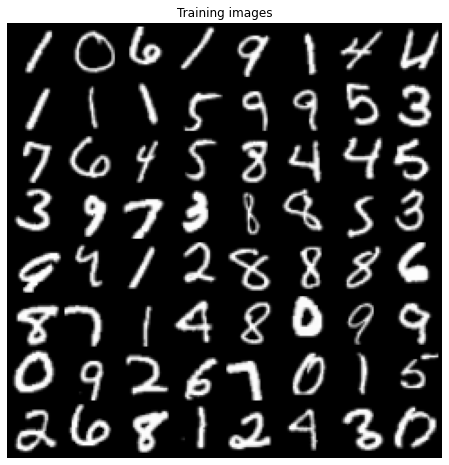

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.utils as vutils

real_batch = next(iter(train_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0][:64], padding=2, normalize=True), (1, 2, 0)
    )
)
plt.show()

## Model

In [10]:
import torch


class PyTorchCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=1,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=1,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(784, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [11]:
import pytorch_lightning as pl
import torchmetrics


# LightningModule that receives a PyTorch model as input
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        # The inherited PyTorch module
        self.model = model

        # Save settings and hyperparameters to the log directory
        # but skip the model parameters
        self.save_hyperparameters(ignore=['model'])

        # Set up attributes for computing the accuracy
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
    # Defining the forward method is only necessary 
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)
        
    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        
        # To account for Dropout behavior during evaluation
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc.update(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()
        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc,
                 on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

## Training

In [12]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

torch.manual_seed(RANDOM_SEED)
pytorch_model = PyTorchCNN(num_classes=NUM_CLASSES)

lightning_model = LightningModel(
    model=pytorch_model, learning_rate=LEARNING_RATE)

callbacks = [ModelCheckpoint(
    save_top_k=1, mode='max', monitor="valid_acc")]  # save top 1 model 
logger = CSVLogger(save_dir="logs/", name="my-model")

In [13]:
import time


trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    progress_bar_refresh_rate=50,  # recommended for notebooks
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    log_every_n_steps=100
)

start_time = time.time()
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader
)

runtime = (time.time() - start_time)/60
print(f"Training took {runtime:.2f} min in total.")

/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=50)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | PyTorchCNN | 103 K 
1 | train_acc | Accuracy   | 0     
2 | valid_acc | Accuracy   | 0     
3 | test_acc  | Accuracy   | 0     
-----------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.413     Tota

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training took 1.78 min in total.


## Evaluation

<AxesSubplot:xlabel='Epoch', ylabel='ACC'>

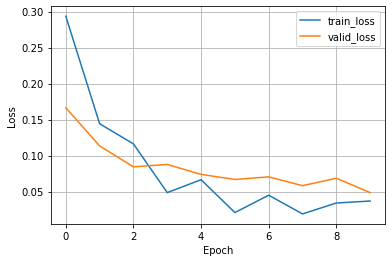

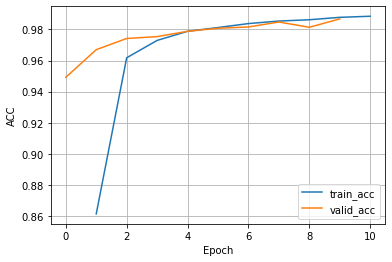

In [14]:
import pandas as pd


metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='ACC')

In [15]:
trainer.test(model=lightning_model, dataloaders=test_loader, ckpt_path='best')

Restoring states from the checkpoint path at logs/my-model/version_1/checkpoints/epoch=9-step=4289.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/my-model/version_1/checkpoints/epoch=9-step=4289.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9907000064849854     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9907000064849854}]

In [16]:
%watermark -iv

torch            : 1.10.1
pandas           : 1.2.5
numpy            : 1.22.2
matplotlib       : 3.3.4
pytorch_lightning: 1.6.0.dev0
torchmetrics     : 0.6.2
torchvision      : 0.11.2

